# Style Transfer

## Setup

In [3]:
import torch
from torch import nn,optim
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

from scipy.misc import imread
from collections import namedtuple
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
def preprocess(img,size=512):   # 规整化图片到imagenet的格式
    transform=T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x:x[None])
    ])
    return transform(img)

def deprocess(img):  # 将规整化的图片还原
    transform=T.Compose([
        T.Lambda(lambda x:x[0]),
        T.Normalize(mean=[0,0,0],
                    std=[1./s for s in [0.229, 0.224, 0.225]]),
        T.Normalize(mean=[-0.485, -0.456, -0.406],
                    std=[1,1,1]),
        T.Lambda(rescale),
        T.ToPILImage()
    ])
    return transform(img)

def rescale(x):  # 缩放到（0，1）
    low,high=x.min(),x.max()
    x_rescaled=(x-low)/(high-low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x-y)/(np.maximum(1e-8,np.abs(x)+np.abs(y))))

def features_from_img(imgpath,imgsize):
    img=preprocess(PIL.Image.open(imgpath),size=imgsize)
    img_var=img.type(dtype)
    return extract_features(img_var,cnn),img_var

def check_scipy():
    import scipy
    vnum=int(scipy.__version__.split('.')[1])
    major_vnum=int(scipy.__version__.split('.')[0])
    assert vnum>=16 or major_vnum>=1,'you must install Scipy>=0.16.0'

check_scipy()
answer=dict(np.load('style-transfer-checks.npz'))

In [10]:
dtype=torch.cuda.FloatTensor

In [11]:
cnn=torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

for param in cnn.parameters():
    param.requires_grad=False

def extract_features(x,cnn):
    features=[]
    prev_feat=x
    for i,module in enumerate(cnn._modules.values()):  # 将features的层以字典显示，并进行遍历
        next_feat=module(prev_feat)
        features.append(next_feat)
        prev_feat=next_feat
    return features

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to C:\Users\lzh/.cache\torch\checkpoints\squeezenet1_1-f364aa15.pth


# Content loss

In [12]:
def content_loss(content_weight,content_current,content_original):
    '''
    Compute the content loss for style transfer
    
    Inputs:
    - content_weight:scalar
    - content_current:(1,C_1,H_1,W_1)
    - content_original:(1,C_1,H_1,W_1)
    
    Returns:
    - scalar content loss
    '''
    N_1,C_1,H_1,W_1=content_current.shape
    F=content_current.view(C_1,H_1*W_1)
    P=content_original.view(C_1,H_1*W_1)
    ct_loss=content_weight*((F-P)**2).sum()
    return ct_loss

In [15]:
# test for content loss
def content_loss_test(correct):
    content_image='styles/tubingen.jpg'
    image_size=192
    content_layer=3
    content_weight=6e-2
    
    c_feats,conten_img_var=features_from_img(content_image,image_size)
    
    bad_img=torch.zeros(*conten_img_var.data.size()).type(dtype)
    feats=extract_features(bad_img,cnn)
    
    student_output=content_loss(content_weight,c_feats[content_layer],feats[content_layer]).cpu().data.numpy()
    error=rel_error(correct,student_output)
    print('maximum error is {:.6f}'.format(error))
content_loss_test(answer['cl_out'])

maximum error is 0.000176


# Style loss

In [16]:
def gram_matrix(features,normalize=True):
    N,C,H,W=features.shape
    x=features.view(N,C,-1)
    gram=torch.matmul(x,x.permute(0,2,1))
    if normalize:
        gram=gram/(H*W*C)
    return gram

In [17]:
# test gram
def gram_matrix_test(correct):
    style_image='styles/starry_night.jpg'
    style_size=192
    feats,_=features_from_img(style_image,style_size)
    student_output=gram_matrix(feats[5].clone()).cpu().data.numpy()
    error=rel_error(correct,student_output)
    print('maximum error is {:.6f}'.format(error))
gram_matrix_test(answer['gm_out'])

maximum error is 0.000000


In [18]:
# style loss
def style_loss(feats,style_layers,style_targets,style_weights):
    loss=0.
    for i,layer in enumerate(style_layers):
        gram_1=gram_matrix(feats[layer])
        gram_2=style_targets[i]
        loss+=style_weights[i]*((gram_1-gram_2)**2).sum()
    return loss

In [20]:
# test style loss
def style_loss_test(correct):
    content_image='styles/tubingen.jpg'
    style_image='styles/starry_night.jpg'
    image_size=192
    style_size=192
    style_layers=[1,4,6,7]
    style_weights=[300000,1000,15,3]
    
    c_feats,_=features_from_img(content_image,image_size)
    feats,_=features_from_img(style_image,style_size)
    style_targets=[]
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    student_output=style_loss(c_feats,style_layers,style_targets,style_weights).cpu().data.numpy()
    error=rel_error(correct,student_output)
    print('error:{:.6f}'.format(error))
style_loss_test(answer['sl_out'])

error:0.000015


In [21]:
# total variation loss
def tv_loss(img,tv_weight):
    loss_w=((img[:,:,:,1:]-img[:,:,:,:-1])**2).sum()
    loss_h=((img[:,:,1:,:]-img[:,:,:-1,:])**2).sum()
    loss=tv_weight*(loss_w+loss_h)
    return loss

In [22]:
# test tv_loss
def tv_loss_test(correct):
    content_img='styles/tubingen.jpg'
    image_size=192
    tv_weight=2e-2
    
    content_img=preprocess(PIL.Image.open(content_img),size=image_size).type(dtype)
    
    student_output=tv_loss(content_img,tv_weight).cpu().data.numpy()
    error=rel_error(correct,student_output)
    print('error:{:.6f}'.format(error))
tv_loss_test(answer['tv_out'])

error:0.000000


In [48]:
def style_transfer(content_image,style_image,image_size,style_size,\
                  content_layer,content_weight,style_layers,style_weights,\
                  tv_weight,init_random=False):
    content_img=preprocess(PIL.Image.open(content_image),size=image_size).type(dtype)
    feats=extract_features(content_img,cnn)
    content_target=feats[content_layer].clone()
    
    style_img=preprocess(PIL.Image.open(style_image),size=style_size).type(dtype)
    feats=extract_features(style_img,cnn)
    style_targets=[]
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    if init_random:
        img=torch.tensor(content_img.size(),dtype=torch.float32).uniform_(0,1).type(dtype)
    else:
        img=content_img.clone().type(dtype)
        print('ok')
    
    img.requires_grad_()
    
    initial_lr=3.
    decayed_lr=0.1
    decay_lr_at=180
    
    optimizer=torch.optim.Adam([img],lr=initial_lr)
    
    f,axarr=plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img')
    axarr[1].set_title('Style Source Img')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t<190:
            img.data.clamp_(-1.5,1.5)
        optimizer.zero_grad()
        feats=extract_features(img,cnn)
        
        c_loss=content_loss(content_weight,feats[content_layer],content_target)
        s_loss=style_loss(feats,style_layers,style_targets,style_weights)
        t_loss=tv_loss(img,tv_weight)
        loss=c_loss+s_loss+t_loss
        
        loss.backward()
        
        if t==decay_lr_at:
            optimizer=torch.optim.Adam([img],lr=decayed_lr)
        optimizer.step()
        
        if t%100==0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

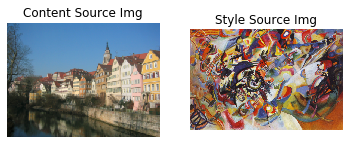

Iteration 0


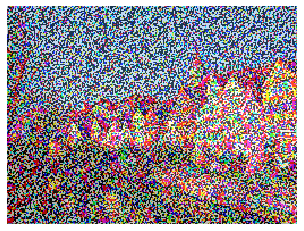

Iteration 100


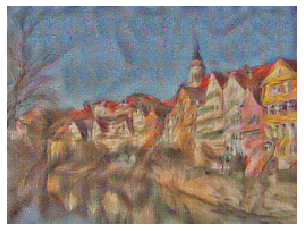

Iteration 199


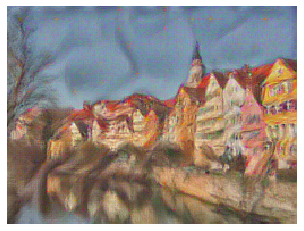

In [37]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

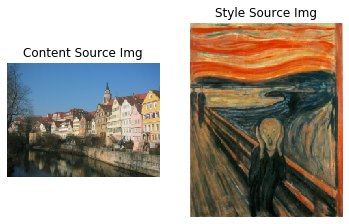

Iteration 0


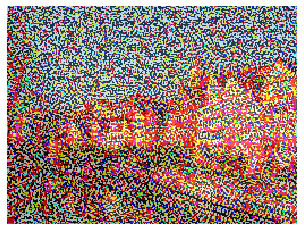

Iteration 100


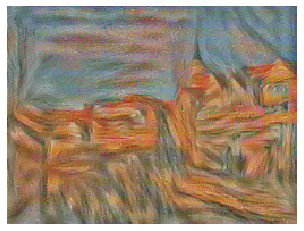

Iteration 199


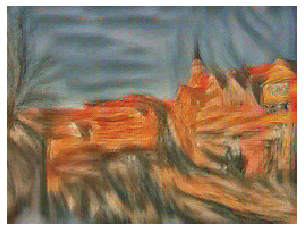

In [32]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

ok


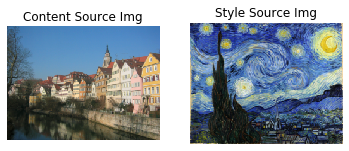

Iteration 0


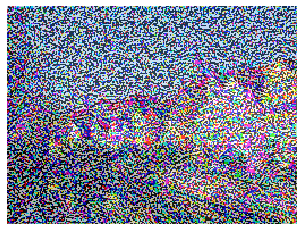

Iteration 100


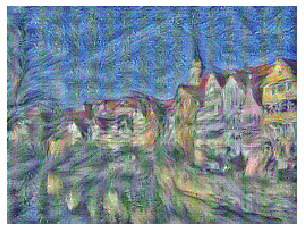

Iteration 199


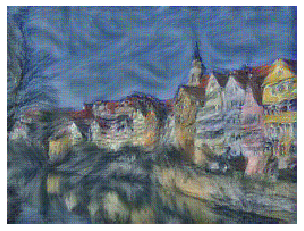

In [50]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

ok


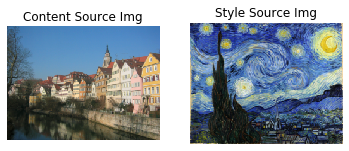

Iteration 0


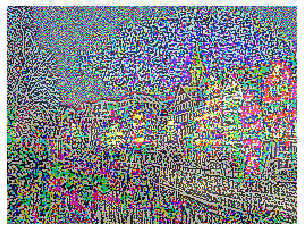

Iteration 100


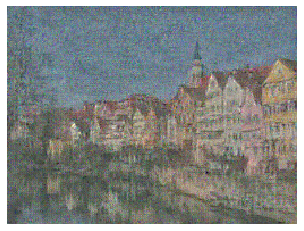

Iteration 199


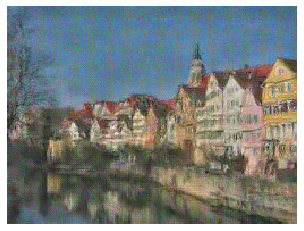

In [49]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,#0,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0],#[300000, 1000, 15, 3], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': False # we want to initialize our image to be random
}

style_transfer(**params_inv)